# Tracking centroids of segmented cells

In [ ]:
%pip install -q --upgrade -r requirements.txt

## Importing packages

`laptrack.LapTrack` is the core object for tracking. 

We also import `regionprops_table` from `skimage` to calculate the centroids of the segmentation masks.

In [1]:
import napari
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from skimage.measure import regionprops_table

from laptrack import LapTrack
from laptrack import datasets

## Load images and showing in napari

First, we load images to the napari viewer.

In [2]:
viewer = napari.Viewer()
data = np.load("cell_segmentation_data/data_small.npz")
images, labels = datasets.cell_segmentation()

viewer.add_image(images)
labels_layer = viewer.add_labels(labels)

## Calculating label centroids by `regionprops_table`

We then calculate the centroids for each labeled region in each frame.

In [3]:
regionprops = []
for frame, label in enumerate(labels):
    df = pd.DataFrame(regionprops_table(label, properties=["label", "centroid"]))
    df["frame"] = frame
    regionprops.append(df)
regionprops_df = pd.concat(regionprops)

## Tracking centroids by LapTrack

 This is where we use `LapTrack`. We track the centroids of the segmented regions.

In [4]:
lt = LapTrack(track_cost_cutoff=15**2, splitting_cost_cutoff=30**2)
track_df, split_df, _ = lt.predict_dataframe(
    regionprops_df.copy(),
    coordinate_cols=["centroid-0", "centroid-1"],
    only_coordinate_cols=False,
)

In [5]:
track_df = track_df.reset_index()
viewer.add_tracks(
    track_df[["track_id", "frame", "centroid-0", "centroid-1"]],
    graph={
        row["child_track_id"]: row["parent_track_id"] for _, row in split_df.iterrows()
    },
)

<Tracks layer 'Tracks' at 0x17fedae60>

## Showing clonal cells by the same colors

To check the result, we show the clonal cell regions by the same colors.

In [6]:
new_labels = np.zeros_like(labels)

for i, row in track_df.iterrows():
    frame = int(row["frame"])
    inds = labels[frame] == row["label"]
    new_labels[frame][inds] = int(row["tree_id"]) + 1
viewer.add_labels(new_labels)
labels_layer.visible = False

([], [])

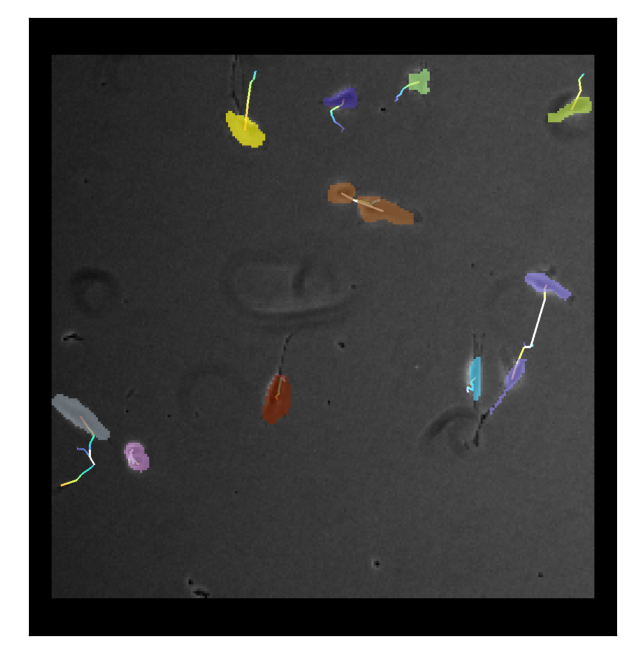

In [7]:
viewer.dims.current_step = (9, 0, 0)
plt.imshow(viewer.screenshot())
plt.xticks([])
plt.yticks([])